In [1]:
import warnings
warnings.filterwarnings('ignore')
try:
    import ujson as json
except ImportError:
    try:
        import simplejson as json
    except ImportError:
        import json
import pickle
import numpy as np
from ipykernel import kernelapp as app
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy import stats
from scipy.integrate import simps
from scipy.spatial import ConvexHull
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

sns.set(font_scale=1.2)

In [2]:
trajectory_file = 'UDysRS_UPDRS_Export/Communication_all_export.txt'

with open(trajectory_file, 'r') as infile:
    comm_dict = json.load(infile)

print("total number of records :{}".format(len(comm_dict.keys())))

total number of records :387


In [3]:
print("Key in Dictionary:",comm_dict['26-1'].keys())
comm_dict['26-1']['position'].pop('face', None)
comm_dict['26-1']['position'].pop('head', None)
comm_dict['26-1']['position'].pop('neck', None)
sorted(comm_dict['26-1']['position'].keys())

Key in Dictionary: dict_keys(['position', 'resp'])


['Lank',
 'Lelb',
 'Lhip',
 'Lkne',
 'Lsho',
 'Lwri',
 'Rank',
 'Relb',
 'Rhip',
 'Rkne',
 'Rsho',
 'Rwri']

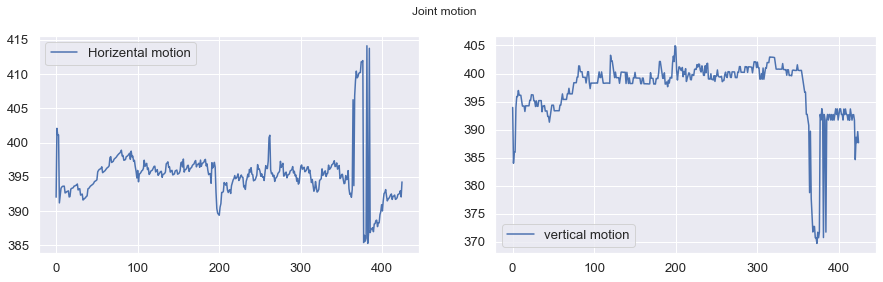

In [4]:
%matplotlib inline
part = "Lank"
horizontal_displacemt_array = np.array(comm_dict['26-1']['position'][part])[:,0]
vertical_displacement_array = np.array(comm_dict['26-1']['position'][part])[:,1]
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(121)
ax.plot(horizontal_displacemt_array,label='Horizental motion')
ax.legend(loc='best')

ax2 = fig.add_subplot(122)
ax2.plot(vertical_displacement_array,label='vertical motion')
ax2.legend(loc='best')

plt.suptitle('Joint motion')
fig.show()

In [5]:
def combinied_horizental_and_vertical(horizental_array, vertical_array):
    combined_array = np.sqrt(np.square(horizental_array) + np.square(vertical_array))
    return combined_array

In [6]:
def convert_into_velocity(dispacement_array, plot=False):
    velocity_array = np.diff(dispacement_array)
    return velocity_array

In [7]:
def convert_into_acceleration(velocity_array, plot=False):
    accelation_array = np.diff(velocity_array)
    return accelation_array

In [8]:
def convert_into_jerk(accelation_array, plot=False):
    jerk_array = np.diff(accelation_array)
    return jerk_array

In [9]:
def get_kinetic_feature(motion):
    max_motion = np.amax(motion, axis=0)
    median_motion = np.median(motion)
    mean_motion = np.mean(motion, axis=0)
    standard_division_motion = np.std(motion)
    IQR_range = stats.iqr(motion, interpolation = 'midpoint')
    return [max_motion, median_motion, mean_motion, standard_division_motion, IQR_range]
# print(get_kinetic_feature(displacemt_array))

{'peak_magnitude': 4.616687312071252,
 'entropy': 3.014613385810386,
 'half_point': 2.5,
 'total_power': 12.677554704215051,
 'power_bands_0.5_to_1': 1.534431046257786,
 'power_bands_0_to_2': 10.163044600116995,
 'power_bands_0_to_4': 12.299129300143314,
 'power_bands_0_to_6': 12.677554704215051}

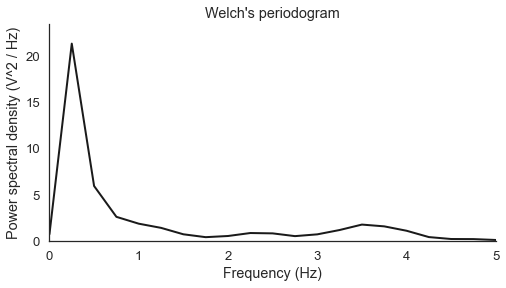

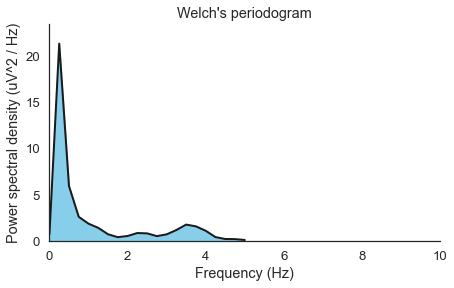

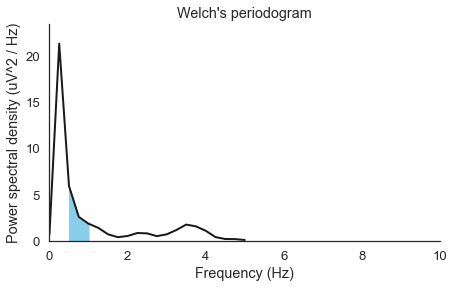

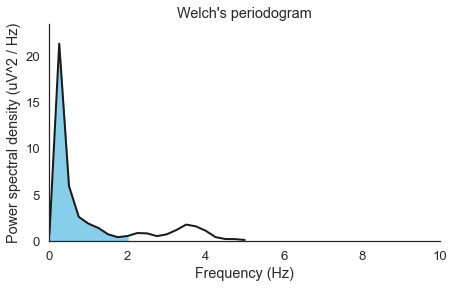

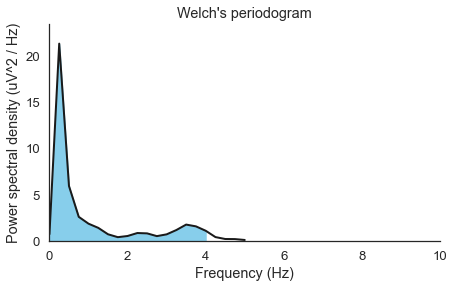

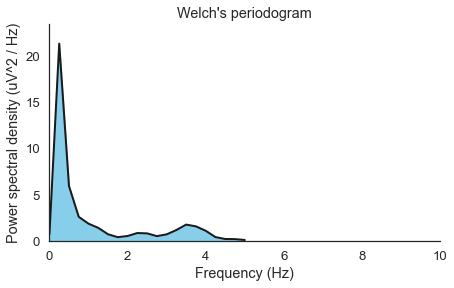

In [10]:
def get_spectral_feature(signals, sample_frequancy=10, is_plot=False):
    sf = sample_frequancy
    win = 4 * sf
    
    # calcutate the Spectral entropy.
    def spectral_entropy(psd, normalize=False):
        psd_norm = np.divide(psd, psd.sum())
        se = -np.multiply(psd_norm, np.log2(psd_norm)).sum()
        if normalize:
            se /= np.log2(psd_norm.size)
        return se
    
    # calculate the power band for given frequancy.
    def bandpower(psd, freqs, min_freqs, max_freqs, is_plot=False):
        # Define delta lower and upper limits
        low, high = min_freqs, max_freqs

        # Find intersecting values in frequency vector
        idx_delta = np.logical_and(freqs >= low, freqs <= high)

        if is_plot:
            # Plot the power spectral density and fill the delta area
            plt.figure(figsize=(7, 4))
            plt.plot(freqs, psd, lw=2, color='k')
            plt.fill_between(freqs, psd, where=idx_delta, color='skyblue')
            plt.xlabel('Frequency (Hz)')
            plt.ylabel('Power spectral density (uV^2 / Hz)')
            plt.xlim([0, 10])
            plt.ylim([0, psd.max() * 1.1])
            plt.title("Welch's periodogram")
            sns.despine()

        # Frequency resolution
        freq_res = freqs[1] - freqs[0]  # = 1 / 4 = 0.25

        # Compute the absolute power by approximating the area under the curve
        delta_power = simps(psd[idx_delta], dx=freq_res)
        #print('Absolute delta power: %.3f uV^2' % delta_power)
        return delta_power

    freqs, psd = signal.welch(signals, sf, nperseg=win)
    if is_plot:
        sns.set(font_scale=1.2, style='white')
        plt.figure(figsize=(8, 4))
        plt.plot(freqs, psd, color='k', lw=2)
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Power spectral density (V^2 / Hz)')
        plt.ylim([0, psd.max() * 1.1])
        plt.title("Welch's periodogram")
        plt.xlim([0, freqs.max()])
        sns.despine()
    #print(dir(psd))
    features = {}
    features["peak_magnitude"] = np.sqrt(psd.max())
    features["entropy"] = spectral_entropy(psd)
    features["half_point"] = freqs.mean()
    
    features["total_power"] = bandpower(psd, freqs, freqs.min(), freqs.max(), is_plot)
    features["power_bands_0.5_to_1"] = bandpower(psd, freqs, 0.5, 1, is_plot)
    features["power_bands_0_to_2"] = bandpower(psd, freqs, 0, 2, is_plot)
    features["power_bands_0_to_4"] = bandpower(psd, freqs, 0, 4, is_plot)
    features["power_bands_0_to_6"] = bandpower(psd, freqs, 0, 6, is_plot)
    return features
get_spectral_feature(vertical_displacement_array, is_plot=True)

In [11]:
# calculate the Area of Convex Hull of joint movement
def get_convexhull(darray):
    hull = ConvexHull(darray)
    return hull.area
get_convexhull(np.array(comm_dict['26-1']['position']["Lank"]))

95.84978188041217

In [12]:
def record_convertion(position_array, position_name, record_id="1-1"):
    position_array = np.array(position_array)
    horizantal_position = position_array[:, 0]
    vertical_position = position_array[:, 1]
    displacement_array = combinied_horizental_and_vertical(horizantal_position, vertical_position) 
    velocity_array = convert_into_velocity(displacement_array)
    accelation_array = convert_into_acceleration(velocity_array)
    jerk_array = convert_into_jerk(accelation_array)
    record = record_id.split("-")

    row = [record_id, int(record[0]), record[1], position_name]
    row.extend(get_kinetic_feature(velocity_array))
    row.extend(get_kinetic_feature(accelation_array))
    row.extend(get_kinetic_feature(jerk_array))
    spectral_feature_displacemt = get_spectral_feature(displacement_array)
    row.extend([value for key, value in spectral_feature_displacemt.items()])
    spectral_feature_velocity = get_spectral_feature(velocity_array)
    row.extend([value for key, value in spectral_feature_velocity.items()])
    convex_hull = get_convexhull(position_array)
    row.extend([convex_hull])
    return row

In [13]:
record_df = pd.DataFrame(columns=["combine_record_id","record_id", "term","position_name",
                                  "speed_max", "speed_median", "speed_mean", "speed_std_div", "speed_iqr_range",
                                 "acceleration_max", "acceleration_median", "acceleration_mean", "acceleration_std_div", "accelerati_iqr_range",
                                 "jerk_max", "jerk_median", "jerk_mean", "jerk_std_div", "jerk_iqr_range",
                                 "displacement_peak_magnitude","displacement_entropy", "displacement_half_point", "displacement_total_power",
                                 "displacement_power_bands_0.5_to_1","displacement_power_bands_0_to_2", "displacement_power_bands_0_to_4", "displacement_power_bands_0_to_6",
                                 "velocity_peak_magnitude","velocity_entropy", "velocity_half_point", "velocity_total_power",
                                 "velocity_power_bands_0.5_to_1","velocity_power_bands_0_to_2", "velocity_power_bands_0_to_4", "velocity_power_bands_0_to_6",
                                 "convexhull"])
index = 0

for record_id, values in comm_dict.items():
    positions = values["position"]
    resp = values["resp"]
    for position_name, position_array in positions.items():
        row = record_convertion(position_array, position_name, record_id)
        record_df.loc[index] = row
        index += 1

record_df.head(10)

,combine_record_id,record_id,term,position_name,speed_max,speed_median,speed_mean,speed_std_div,speed_iqr_range,acceleration_max,...,displacement_power_bands_0_to_6,velocity_peak_magnitude,velocity_entropy,velocity_half_point,velocity_total_power,velocity_power_bands_0.5_to_1,velocity_power_bands_0_to_2,velocity_power_bands_0_to_4,velocity_power_bands_0_to_6,convexhull
0,26-1,26,1,Lkne,3.136361,0.076740,0.002021,0.676698,0.806606,4.786833,...,0.684968,0.405524,4.188976,2.5,0.486046,0.019232,0.099006,0.373697,0.486046,36.917852
1,26-1,26,1,Lwri,5.198535,0.075536,0.016402,1.054253,1.094453,5.487450,...,1.901095,0.581605,4.242219,2.5,1.192271,0.091408,0.389776,0.946561,1.192271,37.675818
2,26-1,26,1,Rkne,3.659338,0.093118,0.029247,0.903657,1.181396,4.980085,...,1.487423,0.563078,4.205455,2.5,0.890508,0.037900,0.210545,0.671195,0.890508,145.438051
3,26-1,26,1,Lelb,2.388729,0.087028,0.006549,0.630261,0.611841,3.936843,...,0.910218,0.399440,4.266713,2.5,0.429022,0.027512,0.135335,0.330622,0.429022,32.153650
4,26-1,26,1,Lsho,3.377126,0.098620,0.001108,0.633851,0.472858,4.691207,...,0.903263,0.362294,4.248869,2.5,0.430376,0.028220,0.135963,0.341566,0.430376,29.343181
5,26-1,26,1,Rhip,3.092405,0.082036,0.021397,0.713963,0.864571,4.181641,...,1.074064,0.473776,4.171686,2.5,0.525334,0.026714,0.127043,0.389940,0.525334,37.914752
6,26-1,26,1,Rank,4.579702,0.077804,0.006936,0.901460,0.899729,4.681347,...,1.739043,0.540726,4.231232,2.5,0.838308,0.044310,0.229761,0.664828,0.838308,61.161962
7,26-1,26,1,Lhip,2.536174,0.077433,0.017686,0.624526,0.751404,3.091574,...,1.202803,0.427129,4.235774,2.5,0.405390,0.027890,0.109671,0.326465,0.405390,37.673377
8,26-1,26,1,Rwri,3.321649,0.087401,-0.006569,0.671034,0.690387,5.181227,...,1.015975,0.440222,4.219854,2.5,0.462217,0.031037,0.120819,0.318026,0.462217,29.350673
9,26-1,26,1,Lank,5.766201,0.074706,-0.006732,1.026969,0.958384,7.775271,...,2.051206,0.697988,4.114266,2.5,1.098217,0.072292,0.234923,0.852103,1.098217,95.849782


In [14]:
rating_file = 'UDysRS_UPDRS_Export/UDysRS.txt'

with open(rating_file, 'r') as infile:
    ratings = json.load(infile)

ratings.keys()

dict_keys(['Communication', 'Drinking', 'Higher'])

In [15]:
ratings['Communication']['2']

[2, 1.5, 1.5, 2.5, 1.5, 1.5]

In [16]:
sub_score_dict = {"Neck":["face"],
        "Larm":["Lsho", "Lelb", "Lwri"],
        "Rarm":["Rsho", "Relb", "Rwri"],
        "Trunk":["Rsho", "Lsho"],
        "Rleg":["Rhip", "Rkne", "Rank"],
        "Lleg":["Lhip", "Lkne", "Lank"]}

#sub_score_dict
groups = record_df.groupby("combine_record_id")
processed_df = pd.DataFrame(columns=["combine_record_id","record_id", "term","position_name","sub_score",
                                  "speed_max", "speed_median", "speed_mean", "speed_std_div", "speed_iqr_range",
                                 "acceleration_max", "acceleration_median", "acceleration_mean", "acceleration_std_div", "accelerati_iqr_range",
                                 "jerk_max", "jerk_median", "jerk_mean", "jerk_std_div", "jerk_iqr_range",
                                     "displacement_peak_magnitude","displacement_entropy", "displacement_half_point", "displacement_total_power",
                                 "displacement_power_bands_0.5_to_1","displacement_power_bands_0_to_2", "displacement_power_bands_0_to_4", "displacement_power_bands_0_to_6",
                                 "velocity_peak_magnitude","velocity_entropy", "velocity_half_point", "velocity_total_power",
                                 "velocity_power_bands_0.5_to_1","velocity_power_bands_0_to_2", "velocity_power_bands_0_to_4", "velocity_power_bands_0_to_6",
                                 "convexhull", "UDysRS_rating"])

def find_rating(record_id, sub_group):
    order = {"Neck":0,
             "Rarm":1,
             "Larm":2,
             "Trunk":3,
             "Rleg":4,
             "Lleg":5}
    try:
        rating = ratings['Communication'][str(record_id)][order[sub_group]]
    except:
        rating = 0
    return rating
    
for record_id, group in groups:
    #print(record_id)
    for index, dict_ in group.iterrows():
        position_name = dict_["position_name"]
        for sub_score, values in sub_score_dict.items():
            if position_name in values:
                #print(key, position_name)
                dict_["sub_score"] = sub_score
                dict_["UDysRS_rating"] = find_rating(dict_["record_id"], sub_score)
                #print(dict_)
                processed_df = processed_df.append(dict_, ignore_index=True)
                
    #print(group.head(17))
processed_df.head()

,combine_record_id,record_id,term,position_name,sub_score,speed_max,speed_median,speed_mean,speed_std_div,speed_iqr_range,...,velocity_peak_magnitude,velocity_entropy,velocity_half_point,velocity_total_power,velocity_power_bands_0.5_to_1,velocity_power_bands_0_to_2,velocity_power_bands_0_to_4,velocity_power_bands_0_to_6,convexhull,UDysRS_rating
0,1-1,1,1,Lkne,Lleg,7.621226,0.000055,-0.009828,1.698062,1.190246,...,0.963329,4.253132,2.5,2.739219,0.199188,0.984690,2.129187,2.739219,88.221826,0.5
1,1-1,1,1,Lwri,Larm,9.038624,0.000233,0.131159,1.042972,0.602927,...,0.828982,3.990733,2.5,0.826367,0.133442,0.527075,0.732966,0.826367,257.148438,1.0
2,1-1,1,1,Rkne,Rleg,3.524555,0.000038,0.007824,0.466179,0.007461,...,0.230852,4.182930,2.5,0.157589,0.006297,0.030704,0.112235,0.157589,21.371593,0.0
3,1-1,1,1,Lelb,Larm,3.696377,-0.000203,-0.065752,0.972254,0.676540,...,0.660396,4.244662,2.5,0.914604,0.122146,0.459827,0.700054,0.914604,116.737246,1.0
4,1-1,1,1,Lsho,Larm,2.462362,-0.000009,-0.009549,0.557721,0.008510,...,0.322026,4.285978,2.5,0.276645,0.018851,0.094961,0.194003,0.276645,39.668787,1.0


In [17]:
grouped_df = processed_df.groupby(['record_id', 'sub_score']).mean().reset_index()
grouped_df.head(7)

,record_id,sub_score,speed_max,speed_median,speed_mean,speed_std_div,speed_iqr_range,acceleration_max,acceleration_median,acceleration_mean,...,velocity_peak_magnitude,velocity_entropy,velocity_half_point,velocity_total_power,velocity_power_bands_0.5_to_1,velocity_power_bands_0_to_2,velocity_power_bands_0_to_4,velocity_power_bands_0_to_6,convexhull,UDysRS_rating
0,1,Larm,2.378699,0.000008,0.006151,0.434431,0.145590,2.563187,-0.000183,-0.002905,...,0.290431,4.180208,2.5,0.257181,0.032530,0.128346,0.204443,0.257181,51.447111,1.0
1,1,Lleg,2.801376,0.000005,-0.002543,0.607632,0.229252,4.019147,0.000188,-0.002594,...,0.331893,4.239766,2.5,0.481217,0.034714,0.156380,0.365744,0.481217,26.924760,0.5
2,1,Neck,3.563685,-0.206350,0.016804,1.104360,0.673869,6.374849,0.025236,-0.001832,...,0.744844,4.114691,2.5,1.166132,0.048349,0.234551,0.750230,1.166132,80.342687,1.5
3,1,Rarm,1.805619,0.000063,0.001008,0.349983,0.031725,2.890424,-0.000061,-0.001641,...,0.200216,4.175002,2.5,0.101611,0.005229,0.024399,0.073403,0.101611,12.233846,0.0
4,1,Rleg,2.280942,0.000060,-0.001827,0.471195,0.038344,2.987845,0.000008,-0.001380,...,0.266186,4.204739,2.5,0.212301,0.011795,0.052896,0.152180,0.212301,17.774876,0.0
5,1,Trunk,1.723720,0.000010,0.000035,0.316521,0.004802,2.431101,-0.000032,-0.002697,...,0.181466,4.227550,2.5,0.096851,0.005998,0.028385,0.069674,0.096851,15.987596,0.5
6,2,Larm,3.313730,0.000220,-0.006432,1.024204,1.352590,2.674307,0.000632,-0.004236,...,1.240900,3.201629,2.5,1.293431,0.236842,1.080049,1.207227,1.293431,46.703959,1.5


In [24]:
sub_score_gr = grouped_df.groupby(["sub_score"])
for sub_score, sub_score_group in sub_score_gr:
    print(sub_score)
    y = sub_score_group["UDysRS_rating"].astype(str)
    X = sub_score_group.drop(['record_id', 'sub_score', 'UDysRS_rating'], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
    #print(X.head())
    clf = DecisionTreeClassifier()
    clf.fit(X_train, y_train)
    filename = '{}_decision_tree_model.sav'.format(sub_score)
    pickle.dump(clf, open(filename, 'wb'))
    print(clf.score(X_test, y_test))

Larm
0.4074074074074074
Lleg
0.25925925925925924
Neck
0.4074074074074074
Rarm
0.5555555555555556
Rleg
0.4444444444444444
Trunk
0.4444444444444444


In [19]:
import warnings
warnings.filterwarnings('ignore')
try:
    import ujson as json
except ImportError:
    try:
        import simplejson as json
    except ImportError:
        import json
import pickle
import numpy as np
from ipykernel import kernelapp as app
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy import stats
from scipy.integrate import simps
from scipy.spatial import ConvexHull
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

sns.set(font_scale=1.2)

In [20]:
# add these graphs and default input as one 

comm_dict = {'Lank': [[941, 847], [955, 849], [973, 858], [981, 876], [1011, 876], [1035, 878], [1072, 888], [1097, 897], [1124, 908], [1149, 919], [1174, 927], [1196, 933], [1210, 941], [1228, 946], [1240, 952], [1252, 962], [1257, 972], [1261, 978], [1258, 980], [1256, 980], [1254, 983], [1248, 987], [1249, 985], [1248, 986], [1248, 986], [1252, 987], [1254, 986], [1256, 986], [1257, 985], [1257, 985], [1256, 980], [1268, 969], [1295, 931], [1313, 940], [1334, 949], [1331, 965], [1336, 964], [1356, 939], [1370, 928], [1406, 921], [1415, 908], [1435, 916], [1450, 919], [1477, 927], [1501, 929], [1538, 995], [1582, 1024], [1596, 1036], [1602, 1050], [1608, 1087], [1616, 1125], [1612, 1147], [1628, 1106], [1635, 1102], [1640, 1116], [1623, 1106], [1642, 1100], [1645, 1091], [1646, 1087], [1662, 1140], [1659, 1137], [1654, 1172], [1650, 1192], [1656, 1224], [1651, 1230], [1647, 1235], [1644, 1281], [1643, 1310], [1642, 1338], [1637, 1357], [1606, 1342], [1582, 1316], [1588, 1312], [1599, 1258], [1567, 1240], [1465, 1314], [1487, 1255], [1462, 1286], [1425, 1332], [1433, 1329], [1367, 1347], [1371, 1335], [1354, 1377], [1456, 1362], [1463, 1359], [1539, 1354], [1382, 1352], [1297, 1419], [1282, 1397], [1336, 1410], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [406, 137], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [548, 211], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [182, 978], [178, 978], [168, 978], [163, 987], [158, 1005], [159, 1006], [159, 1006], [160, 1014], [159, 1028], [159, 1037], [160, 1032], [162, 1028], [167, 1015], [174, 999], [180, 977], [187, 959], [195, 953], [211, 923], [224, 918], [240, 904], [256, 895], [275, 868], [293, 854], [309, 842], [326, 819], [341, 798], [360, 785], [386, 766], [410, 746], [430, 751], [497, 774], [698, 747], [611, 765], [586, 757], [622, 749], [659, 621], [642, 627], [613, 671], [636, 658], [642, 617], [665, 596], [664, 608], [656, 629], [717, 625], [681, 700], [693, 705], [679, 696], [684, 695], [690, 670], [714, 670], [721, 670], [753, 658], [737, 659], [754, 659], [751, 650], [772, 606], [766, 624]], 'Lelb': [[1157, 199], [1161, 200], [1168, 201], [1177, 201], [1188, 201], [1196, 201], [1204, 201], [1219, 199], [1232, 198], [1242, 197], [1252, 196], [1261, 196], [1273, 199], [1284, 204], [1291, 215], [1306, 230], [1314, 240], [1324, 247], [1336, 257], [1340, 269], [1352, 276], [1361, 285], [1382, 292], [1397, 293], [1415, 294], [1431, 292], [1444, 289], [1460, 288], [1476, 283], [1485, 274], [1494, 264], [1502, 255], [1514, 256], [1518, 254], [1520, 251], [1524, 252], [1528, 256], [1529, 267], [1531, 279], [1536, 288], [1541, 298], [1544, 319], [1549, 339], [1548, 348], [1550, 351], [1548, 358], [1546, 362], [1546, 356], [1544, 356], [1541, 355], [1539, 353], [1536, 337], [1533, 315], [1537, 297], [1547, 278], [1541, 256], [1580, 229], [1591, 249], [1625, 246], [1656, 243], [1530, 239], [1264, 239], [1701, 226], [1770, 217], [1807, 222], [1828, 223], [1839, 223], [1867, 224], [1876, 224], [1869, 223], [1847, 219], [1830, 216], [1824, 213], [1822, 206], [1787, 190], [1172, 248], [1555, 211], [1114, 223], [1075, 223], [1044, 219], [1011, 214], [996, 206], [970, 191], [951, 169], [915, 156], [877, 154], [852, 146], [827, 146], [808, 149], [807, 152], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [1114, 222], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [388, 187], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [24, 286], [24, 296], [36, 306], [48, 314], [66, 321], [93, 322], [111, 326], [143, 326], [164, 324], [184, 323], [205, 286], [231, 284], [279, 276], [327, 222], [344, 195], [348, 225], [359, 221], [365, 223], [376, 222], [373, 225], [369, 226], [367, 247], [367, 267], [371, 281], [376, 298], [376, 313], [374, 319], [376, 317], [382, 321], [383, 319], [382, 319], [381, 315], [380, 312], [379, 298], [383, 274], [391, 258], [399, 247], [410, 237], [420, 232], [436, 223], [448, 221], [460, 223], [474, 225], [494, 222], [508, 225], [525, 226], [544, 230], [561, 238], [576, 240], [597, 240], [613, 239], [638, 234], [650, 216], [648, 217], [665, 214], [676, 211], [672, 210]], 'Lhip': [[1014, 513], [1019, 517], [1027, 517], [1037, 517], [1048, 517], [1056, 516], [1070, 512], [1083, 507], [1093, 504], [1105, 499], [1115, 496], [1127, 490], [1138, 486], [1151, 484], [1162, 484], [1175, 481], [1189, 482], [1202, 483], [1215, 488], [1223, 491], [1237, 499], [1251, 502], [1263, 516], [1276, 524], [1283, 527], [1293, 524], [1299, 522], [1307, 522], [1315, 521], [1324, 520], [1335, 519], [1342, 508], [1354, 500], [1359, 494], [1370, 487], [1377, 489], [1391, 490], [1408, 491], [1417, 492], [1433, 493], [1445, 499], [1454, 523], [1470, 547], [1478, 559], [1490, 570], [1500, 571], [1508, 570], [1513, 568], [1525, 572], [1523, 568], [1533, 566], [1527, 565], [1531, 550], [1532, 530], [1528, 521], [1526, 519], [1525, 508], [1541, 508], [1553, 510], [1561, 512], [1556, 513], [1533, 530], [1541, 535], [1562, 549], [1572, 560], [1577, 569], [1576, 588], [1579, 604], [1578, 613], [1578, 613], [1568, 616], [1540, 612], [1541, 593], [1543, 581], [1514, 573], [1377, 574], [1437, 567], [1369, 563], [1326, 561], [1319, 552], [1295, 554], [1304, 554], [1285, 579], [1309, 585], [1314, 605], [1303, 624], [1247, 630], [1217, 655], [1203, 661], [1227, 678], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [865, 264], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [703, 339], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [140, 504], [148, 514], [157, 517], [167, 516], [174, 517], [178, 514], [189, 513], [202, 510], [213, 506], [223, 503], [238, 482], [250, 467], [270, 454], [297, 440], [323, 430], [341, 417], [344, 416], [352, 405], [358, 411], [372, 412], [378, 415], [392, 418], [404, 418], [412, 433], [417, 455], [426, 466], [434, 477], [443, 486], [451, 491], [459, 490], [467, 487], [474, 484], [482, 482], [493, 476], [502, 463], [511, 440], [520, 423], [531, 414], [540, 402], [553, 391], [568, 384], [576, 376], [586, 378], [596, 369], [602, 362], [611, 356], [625, 351], [632, 348], [635, 339], [654, 335], [658, 330], [671, 328], [664, 326], [670, 326], [673, 325], [680, 321], [691, 324]], 'Lkne': [[1046, 716], [1058, 717], [1071, 718], [1080, 719], [1094, 719], [1105, 719], [1118, 716], [1140, 717], [1152, 718], [1167, 718], [1179, 718], [1187, 715], [1199, 715], [1211, 715], [1221, 716], [1226, 719], [1234, 729], [1244, 735], [1251, 738], [1257, 739], [1266, 748], [1266, 759], [1273, 768], [1283, 771], [1289, 780], [1295, 777], [1303, 775], [1312, 778], [1318, 776], [1326, 775], [1335, 774], [1347, 759], [1353, 750], [1358, 752], [1362, 752], [1363, 753], [1381, 762], [1399, 764], [1418, 766], [1447, 774], [1483, 776], [1502, 803], [1535, 811], [1555, 815], [1565, 822], [1571, 821], [1588, 821], [1599, 829], [1607, 852], [1602, 856], [1607, 856], [1591, 856], [1589, 851], [1587, 842], [1589, 840], [1580, 840], [1591, 826], [1597, 826], [1596, 828], [1600, 845], [1578, 854], [1564, 881], [1564, 903], [1595, 934], [1601, 952], [1609, 963], [1613, 986], [1617, 999], [1619, 1006], [1617, 1017], [1616, 1022], [1587, 1005], [1600, 1005], [1604, 1001], [1547, 992], [1350, 992], [1441, 957], [1363, 958], [1390, 962], [1409, 962], [1366, 963], [1400, 971], [1297, 1012], [1366, 1011], [1400, 1030], [1424, 1045], [1299, 1062], [1211, 1100], [1229, 1080], [1268, 1133], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [641, 206], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [689, 420], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [164, 728], [171, 755], [179, 753], [182, 756], [188, 755], [192, 757], [203, 751], [207, 752], [209, 753], [220, 742], [216, 742], [226, 741], [233, 706], [247, 691], [256, 682], [281, 685], [289, 672], [307, 652], [314, 652], [326, 648], [342, 649], [360, 641], [381, 643], [395, 644], [418, 647], [430, 647], [444, 647], [466, 642], [482, 631], [504, 630], [552, 640], [591, 623], [602, 626], [614, 628], [606, 611], [625, 479], [634, 472], [615, 523], [615, 523], [621, 522], [662, 450], [669, 478], [676, 493], [691, 491], [704, 526], [710, 527], [727, 530], [731, 527], [734, 504], [751, 501], [737, 496], [758, 486], [747, 484], [751, 486], [757, 480], [752, 460], [749, 463]], 'Lsho': [[1033, 132], [1043, 133], [1050, 133], [1060, 136], [1071, 136], [1077, 136], [1090, 131], [1103, 123], [1120, 115], [1137, 104], [1156, 94], [1169, 81], [1191, 80], [1214, 79], [1235, 80], [1263, 85], [1288, 94], [1310, 106], [1331, 118], [1358, 132], [1383, 152], [1403, 176], [1429, 193], [1458, 208], [1484, 224], [1513, 233], [1542, 244], [1579, 246], [1610, 263], [1634, 276], [1638, 291], [1653, 306], [1675, 326], [1675, 332], [1676, 342], [1679, 349], [1677, 356], [1677, 359], [1677, 363], [1682, 366], [1680, 367], [1686, 374], [1685, 378], [1683, 373], [1686, 372], [1683, 370], [1679, 368], [1671, 361], [1663, 351], [1657, 332], [1652, 324], [1652, 305], [1652, 293], [1666, 279], [1677, 270], [1676, 256], [1705, 251], [1740, 249], [1777, 252], [1820, 256], [1547, 250], [1163, 252], [1852, 261], [1965, 283], [2031, 300], [2062, 301], [2097, 298], [2144, 282], [2158, 262], [2161, 261], [2141, 262], [2097, 268], [2080, 269], [2058, 272], [2037, 276], [1031, 207], [1829, 295], [954, 190], [912, 170], [868, 162], [826, 163], [794, 166], [756, 167], [742, 172], [678, 174], [642, 177], [615, 178], [581, 179], [558, 180], [558, 180], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [1142, 305], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [194, 145], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [118, 369], [126, 369], [130, 371], [140, 384], [146, 387], [162, 389], [191, 388], [204, 401], [234, 401], [257, 402], [281, 378], [296, 378], [328, 368], [391, 220], [399, 159], [383, 271], [426, 167], [425, 196], [428, 205], [426, 322], [426, 308], [417, 322], [418, 343], [415, 333], [420, 351], [425, 344], [430, 354], [440, 361], [440, 377], [442, 388], [439, 398], [434, 419], [420, 414], [413, 406], [411, 400], [412, 399], [412, 390], [413, 371], [420, 357], [431, 349], [445, 349], [457, 351], [470, 353], [482, 350], [496, 351], [513, 354], [534, 364], [551, 369], [568, 371], [586, 372], [611, 372], [638, 366], [665, 320], [677, 315], [677, 310], [683, 294], [693, 287]], 'Lwri': [[1033, 132], [1043, 133], [1050, 133], [1060, 136], [1071, 136], [1077, 136], [1090, 131], [1103, 123], [1120, 115], [1137, 104], [1156, 94], [1169, 81], [1191, 80], [1214, 79], [1235, 80], [1263, 85], [1288, 94], [1310, 106], [1331, 118], [1358, 132], [1383, 152], [1403, 176], [1429, 193], [1458, 208], [1484, 224], [1513, 233], [1542, 244], [1579, 246], [1610, 263], [1634, 276], [1638, 291], [1653, 306], [1675, 326], [1675, 332], [1676, 342], [1679, 349], [1677, 356], [1677, 359], [1677, 363], [1682, 366], [1680, 367], [1686, 374], [1685, 378], [1683, 373], [1686, 372], [1683, 370], [1679, 368], [1671, 361], [1663, 351], [1657, 332], [1652, 324], [1652, 305], [1652, 293], [1666, 279], [1677, 270], [1676, 256], [1705, 251], [1740, 249], [1777, 252], [1820, 256], [1547, 250], [1163, 252], [1852, 261], [1965, 283], [2031, 300], [2062, 301], [2097, 298], [2144, 282], [2158, 262], [2161, 261], [2141, 262], [2097, 268], [2080, 269], [2058, 272], [2037, 276], [1031, 207], [1829, 295], [954, 190], [912, 170], [868, 162], [826, 163], [794, 166], [756, 167], [742, 172], [678, 174], [642, 177], [615, 178], [581, 179], [558, 180], [558, 180], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [1142, 305], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [194, 145], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [118, 369], [126, 369], [130, 371], [140, 384], [146, 387], [162, 389], [191, 388], [204, 401], [234, 401], [257, 402], [281, 378], [296, 378], [328, 368], [391, 220], [399, 159], [383, 271], [426, 167], [425, 196], [428, 205], [426, 322], [426, 308], [417, 322], [418, 343], [415, 333], [420, 351], [425, 344], [430, 354], [440, 361], [440, 377], [442, 388], [439, 398], [434, 419], [420, 414], [413, 406], [411, 400], [412, 399], [412, 390], [413, 371], [420, 357], [431, 349], [445, 349], [457, 351], [470, 353], [482, 350], [496, 351], [513, 354], [534, 364], [551, 369], [568, 371], [586, 372], [611, 372], [638, 366], [665, 320], [677, 315], [677, 310], [683, 294], [693, 287]], 'Rank': [[981, 904], [981, 902], [982, 901], [993, 894], [992, 894], [999, 891], [998, 892], [998, 889], [997, 895], [997, 896], [997, 895], [999, 895], [1001, 895], [1001, 896], [1001, 894], [1004, 894], [1008, 889], [1011, 889], [1014, 883], [1017, 879], [1024, 879], [1041, 863], [1052, 867], [1062, 869], [1066, 873], [1088, 877], [1119, 878], [1150, 883], [1170, 917], [1204, 955], [1245, 969], [1274, 969], [1318, 1022], [1341, 1021], [1364, 1016], [1399, 1031], [1425, 1045], [1444, 1041], [1454, 1039], [1477, 1045], [1502, 1054], [1515, 1054], [1527, 1070], [1536, 1085], [1538, 1094], [1542, 1084], [1523, 1077], [1514, 1073], [1515, 1125], [1526, 1162], [1539, 1157], [1563, 1169], [1549, 1157], [1547, 1103], [1541, 1101], [1544, 1096], [1525, 1140], [1503, 1111], [1497, 1102], [1491, 1181], [1500, 1180], [1505, 1209], [1501, 1223], [1445, 1244], [1453, 1250], [1443, 1249], [1436, 1286], [1422, 1309], [1426, 1339], [1434, 1353], [1436, 1333], [1430, 1333], [1386, 1322], [1359, 1297], [1366, 1288], [1525, 1316], [1443, 1296], [1472, 1296], [1494, 1320], [1487, 1323], [1527, 1330], [1504, 1333], [1627, 1342], [1591, 1338], [1587, 1336], [1498, 1335], [1532, 1304], [1546, 1306], [1532, 1289], [1414, 1345], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [505, 241], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [533, 160], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [156, 975], [156, 987], [196, 989], [225, 992], [244, 974], [260, 969], [276, 967], [302, 963], [327, 960], [356, 952], [384, 935], [406, 918], [422, 918], [442, 914], [454, 913], [467, 912], [472, 913], [479, 904], [485, 903], [492, 900], [484, 902], [484, 900], [481, 900], [477, 906], [477, 911], [478, 913], [476, 916], [475, 916], [475, 917], [474, 917], [473, 917], [471, 917], [470, 916], [470, 913], [472, 907], [475, 901], [482, 892], [495, 878], [511, 867], [519, 846], [522, 823], [527, 803], [535, 791], [542, 782], [554, 757], [563, 740], [578, 724], [593, 708], [609, 695], [624, 681], [645, 662], [656, 640], [676, 609], [701, 583], [717, 567], [742, 597], [778, 614]], 'Relb': [[855, 117], [860, 127], [876, 131], [888, 135], [903, 136], [919, 139], [933, 156], [945, 159], [946, 156], [956, 157], [963, 165], [967, 180], [968, 187], [971, 201], [970, 217], [971, 239], [971, 257], [971, 281], [972, 300], [971, 313], [972, 327], [975, 341], [977, 349], [978, 354], [978, 355], [982, 350], [982, 345], [991, 340], [998, 334], [1001, 318], [1006, 293], [1012, 271], [1030, 247], [1047, 226], [1057, 214], [1060, 207], [1062, 204], [1063, 196], [1058, 192], [1056, 189], [1056, 185], [1062, 184], [1065, 186], [1068, 187], [1073, 190], [1076, 192], [1077, 193], [1083, 194], [1091, 197], [1090, 197], [1094, 197], [1107, 197], [1123, 199], [1131, 200], [1152, 204], [1310, 289], [1229, 274], [1199, 257], [1206, 252], [1206, 257], [1425, 272], [1722, 258], [1386, 286], [1291, 308], [1270, 329], [1271, 350], [1270, 364], [1265, 371], [1264, 372], [1254, 367], [1256, 357], [1254, 346], [1239, 325], [1223, 301], [1188, 290], [1755, 222], [1200, 241], [1761, 240], [1693, 213], [1658, 209], [1632, 218], [1624, 224], [1604, 228], [1580, 241], [1569, 247], [1530, 282], [1509, 306], [1494, 327], [1499, 309], [1439, 315], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [1220, 304], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [451, 285], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [353, 329], [353, 352], [353, 368], [355, 380], [356, 379], [357, 378], [357, 374], [357, 363], [359, 348], [360, 332], [366, 310], [372, 294], [378, 272], [383, 263], [386, 249], [387, 229], [410, 236], [423, 234], [432, 238], [444, 244], [462, 247], [482, 264], [499, 282], [519, 309], [538, 332], [556, 352], [580, 365], [596, 371], [614, 375], [633, 369], [666, 370], [690, 364], [710, 364], [736, 343], [752, 317], [765, 289], [776, 265], [788, 244], [801, 233], [812, 222], [813, 210], [820, 205], [826, 205], [829, 204], [826, 205], [825, 202], [828, 200], [832, 201], [831, 199], [830, 200], [835, 201], [843, 202], [850, 202], [858, 207], [863, 207], [870, 209], [879, 212]], 'Rhip': [[929, 516], [933, 519], [939, 519], [946, 518], [959, 518], [967, 517], [979, 515], [984, 513], [989, 512], [998, 508], [1005, 506], [1015, 498], [1025, 494], [1037, 491], [1049, 491], [1058, 486], [1072, 487], [1087, 488], [1100, 490], [1114, 496], [1127, 504], [1144, 511], [1156, 522], [1170, 532], [1175, 532], [1183, 529], [1185, 528], [1194, 527], [1200, 526], [1214, 526], [1225, 525], [1232, 522], [1245, 518], [1247, 508], [1255, 499], [1265, 499], [1272, 499], [1287, 500], [1291, 500], [1315, 502], [1323, 512], [1329, 531], [1349, 559], [1355, 572], [1365, 586], [1375, 588], [1375, 588], [1378, 584], [1394, 587], [1396, 583], [1399, 581], [1416, 579], [1417, 567], [1416, 544], [1425, 536], [1445, 531], [1435, 523], [1422, 523], [1419, 531], [1418, 537], [1433, 538], [1497, 543], [1480, 548], [1423, 565], [1413, 574], [1405, 579], [1405, 595], [1401, 610], [1396, 618], [1396, 620], [1402, 624], [1400, 621], [1373, 594], [1367, 589], [1364, 571], [1497, 571], [1399, 565], [1458, 551], [1464, 552], [1455, 551], [1454, 553], [1424, 554], [1435, 561], [1399, 585], [1383, 611], [1360, 630], [1337, 634], [1350, 644], [1329, 652], [1263, 671], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [874, 343], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [710, 299], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [239, 506], [244, 514], [253, 519], [262, 519], [268, 520], [274, 518], [284, 517], [296, 508], [310, 504], [323, 495], [335, 472], [345, 456], [361, 446], [375, 433], [383, 423], [386, 409], [404, 406], [411, 397], [421, 402], [437, 404], [447, 409], [462, 411], [483, 417], [491, 437], [500, 458], [508, 470], [516, 483], [523, 493], [530, 501], [535, 503], [544, 500], [549, 497], [554, 495], [563, 495], [576, 480], [582, 460], [591, 437], [602, 430], [617, 419], [626, 408], [636, 398], [644, 389], [652, 385], [668, 377], [670, 366], [676, 361], [683, 355], [688, 348], [700, 340], [701, 336], [711, 328], [720, 330], [731, 327], [741, 327], [745, 325], [756, 317], [768, 319]], 'Rkne': [[963, 730], [958, 736], [952, 740], [953, 744], [961, 745], [975, 745], [980, 742], [984, 743], [987, 742], [991, 742], [994, 739], [997, 729], [1003, 727], [1013, 726], [1023, 726], [1032, 726], [1044, 735], [1062, 743], [1076, 747], [1100, 750], [1115, 758], [1138, 766], [1146, 773], [1160, 776], [1165, 773], [1195, 764], [1202, 751], [1228, 756], [1234, 756], [1249, 763], [1251, 774], [1271, 774], [1296, 787], [1295, 784], [1300, 783], [1321, 781], [1333, 786], [1334, 784], [1346, 785], [1391, 797], [1395, 817], [1397, 838], [1426, 866], [1445, 875], [1461, 886], [1461, 881], [1442, 888], [1433, 886], [1438, 895], [1444, 897], [1446, 907], [1481, 899], [1467, 885], [1462, 860], [1463, 853], [1480, 848], [1474, 843], [1443, 849], [1437, 857], [1436, 874], [1439, 873], [1460, 891], [1460, 914], [1427, 959], [1420, 975], [1408, 999], [1402, 1011], [1395, 1028], [1394, 1032], [1393, 1042], [1385, 1029], [1388, 1018], [1340, 1000], [1317, 986], [1326, 964], [1500, 966], [1365, 957], [1491, 947], [1518, 950], [1485, 952], [1489, 954], [1456, 964], [1568, 987], [1478, 991], [1425, 997], [1380, 1012], [1414, 1008], [1483, 1014], [1479, 1012], [1307, 1078], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [734, 324], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [674, 276], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [295, 757], [306, 759], [319, 759], [327, 760], [341, 755], [335, 749], [336, 743], [355, 734], [372, 724], [400, 710], [418, 684], [426, 676], [438, 670], [442, 663], [448, 658], [445, 659], [453, 653], [464, 638], [469, 642], [476, 645], [489, 647], [497, 644], [505, 649], [510, 662], [521, 675], [531, 684], [541, 691], [551, 696], [568, 699], [573, 705], [571, 707], [565, 710], [562, 711], [564, 708], [561, 707], [560, 705], [568, 680], [574, 667], [589, 642], [600, 625], [613, 608], [622, 596], [646, 590], [656, 591], [688, 578], [701, 563], [714, 560], [734, 545], [744, 537], [756, 526], [778, 509], [790, 502], [803, 486], [828, 474], [834, 456], [815, 451], [809, 469]], 'Rsho': [[917, 131], [917, 130], [921, 130], [927, 130], [935, 130], [940, 130], [951, 130], [967, 122], [979, 106], [990, 92], [997, 84], [1005, 65], [1009, 62], [1009, 60], [1012, 62], [1017, 66], [1028, 78], [1046, 111], [1054, 144], [1064, 169], [1069, 198], [1068, 238], [1065, 251], [1063, 260], [1062, 276], [1060, 274], [1058, 269], [1041, 265], [1037, 258], [1054, 256], [1060, 254], [1049, 250], [1030, 236], [1022, 226], [998, 218], [994, 208], [985, 199], [964, 195], [931, 191], [913, 185], [904, 180], [900, 175], [895, 170], [890, 167], [891, 163], [894, 160], [894, 159], [898, 157], [901, 156], [901, 155], [902, 154], [910, 153], [934, 154], [953, 155], [986, 161], [1360, 281], [1142, 245], [1090, 226], [1093, 222], [1108, 231], [1469, 310], [1872, 286], [1289, 278], [1180, 285], [1161, 290], [1163, 295], [1159, 293], [1153, 291], [1152, 289], [1140, 281], [1134, 269], [1120, 256], [1096, 237], [1073, 226], [1034, 211], [1949, 281], [1036, 206], [1901, 320], [1885, 335], [1856, 352], [1828, 363], [1809, 383], [1778, 390], [1751, 400], [1726, 414], [1705, 420], [1697, 423], [1677, 428], [1609, 420], [1550, 418], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [1331, 369], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [264, 280], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [436, 444], [436, 455], [436, 461], [437, 474], [439, 477], [443, 476], [445, 474], [449, 468], [450, 452], [457, 434], [464, 416], [472, 397], [481, 381], [485, 373], [492, 356], [491, 342], [505, 341], [513, 338], [524, 338], [535, 344], [554, 348], [581, 359], [590, 370], [606, 390], [622, 407], [642, 425], [671, 439], [683, 435], [708, 431], [726, 428], [752, 409], [759, 375], [770, 344], [785, 306], [791, 281], [797, 261], [807, 241], [819, 218], [826, 201], [832, 193], [844, 189], [855, 190], [858, 189], [857, 196], [869, 206], [878, 215], [887, 232], [894, 252], [898, 263], [898, 274], [906, 286], [915, 300], [916, 304], [924, 311], [930, 313], [940, 315], [948, 313]], 'Rwri': [[917, 131], [917, 130], [921, 130], [927, 130], [935, 130], [940, 130], [951, 130], [967, 122], [979, 106], [990, 92], [997, 84], [1005, 65], [1009, 62], [1009, 60], [1012, 62], [1017, 66], [1028, 78], [1046, 111], [1054, 144], [1064, 169], [1069, 198], [1068, 238], [1065, 251], [1063, 260], [1062, 276], [1060, 274], [1058, 269], [1041, 265], [1037, 258], [1054, 256], [1060, 254], [1049, 250], [1030, 236], [1022, 226], [998, 218], [994, 208], [985, 199], [964, 195], [931, 191], [913, 185], [904, 180], [900, 175], [895, 170], [890, 167], [891, 163], [894, 160], [894, 159], [898, 157], [901, 156], [901, 155], [902, 154], [910, 153], [934, 154], [953, 155], [986, 161], [1360, 281], [1142, 245], [1090, 226], [1093, 222], [1108, 231], [1469, 310], [1872, 286], [1289, 278], [1180, 285], [1161, 290], [1163, 295], [1159, 293], [1153, 291], [1152, 289], [1140, 281], [1134, 269], [1120, 256], [1096, 237], [1073, 226], [1034, 211], [1949, 281], [1036, 206], [1901, 320], [1885, 335], [1856, 352], [1828, 363], [1809, 383], [1778, 390], [1751, 400], [1726, 414], [1705, 420], [1697, 423], [1677, 428], [1609, 420], [1550, 418], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [1331, 369], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [264, 280], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [436, 444], [436, 455], [436, 461], [437, 474], [439, 477], [443, 476], [445, 474], [449, 468], [450, 452], [457, 434], [464, 416], [472, 397], [481, 381], [485, 373], [492, 356], [491, 342], [505, 341], [513, 338], [524, 338], [535, 344], [554, 348], [581, 359], [590, 370], [606, 390], [622, 407], [642, 425], [671, 439], [683, 435], [708, 431], [726, 428], [752, 409], [759, 375], [770, 344], [785, 306], [791, 281], [797, 261], [807, 241], [819, 218], [826, 201], [832, 193], [844, 189], [855, 190], [858, 189], [857, 196], [869, 206], [878, 215], [887, 232], [894, 252], [898, 263], [898, 274], [906, 286], [915, 300], [916, 304], [924, 311], [930, 313], [940, 315], [948, 313]]}

print("total number of records :{}".format(len(comm_dict.keys())))

total number of records :12


In [21]:
print("Key in Dictionary:",comm_dict.keys())

Key in Dictionary: dict_keys(['Lank', 'Lelb', 'Lhip', 'Lkne', 'Lsho', 'Lwri', 'Rank', 'Relb', 'Rhip', 'Rkne', 'Rsho', 'Rwri'])


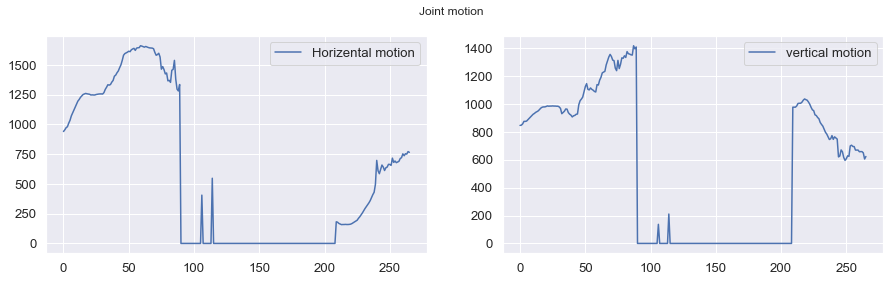

In [22]:
    %matplotlib inline
    part = "Lank"
    horizontal_displacemt_array = np.array(comm_dict[part])[:,0]
    vertical_displacement_array = np.array(comm_dict[part])[:,1]
    fig = plt.figure(figsize=(15, 4))
    ax = fig.add_subplot(121)
    ax.plot(horizontal_displacemt_array,label='Horizental motion')
    ax.legend(loc='best')

    ax2 = fig.add_subplot(122)
    ax2.plot(vertical_displacement_array,label='vertical motion')
    ax2.legend(loc='best')

    plt.suptitle('Joint motion')
    fig.show()

{'peak_magnitude': 298.65453369034236,
 'entropy': 2.338088145992246,
 'half_point': 2.5,
 'total_power': 44065.442764816486,
 'power_bands_0.5_to_1': 5161.005037572766,
 'power_bands_0_to_2': 42023.144328976035,
 'power_bands_0_to_4': 43543.04962467708,
 'power_bands_0_to_6': 44065.442764816486}

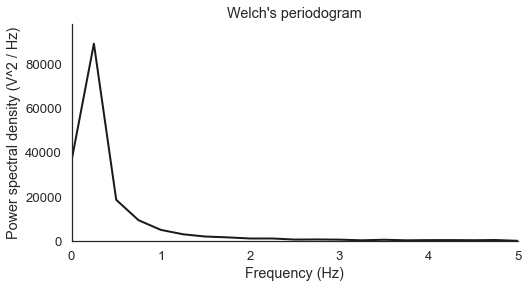

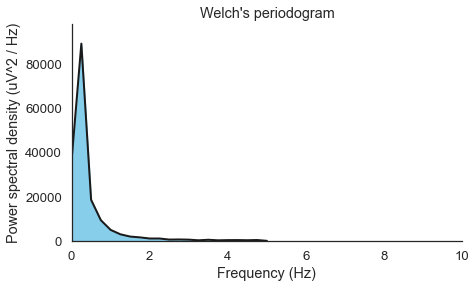

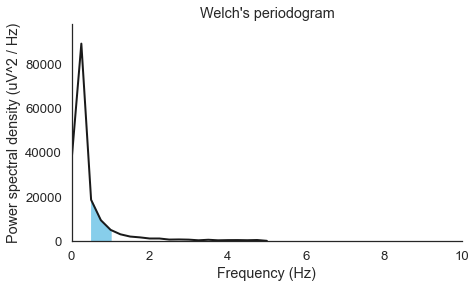

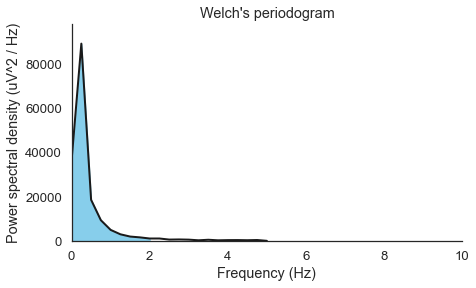

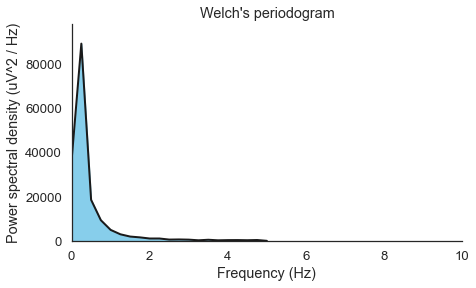

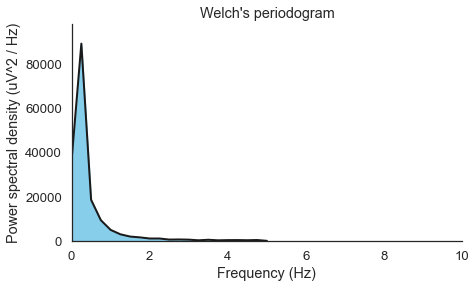

In [23]:
def combinied_horizental_and_vertical(horizental_array, vertical_array):
    combined_array = np.sqrt(np.square(horizental_array) + np.square(vertical_array))
    return combined_array

def convert_into_velocity(dispacement_array, plot=False):
    velocity_array = np.diff(dispacement_array)
    return velocity_array

def convert_into_acceleration(velocity_array, plot=False):
    accelation_array = np.diff(velocity_array)
    return accelation_array

def convert_into_jerk(accelation_array, plot=False):
    jerk_array = np.diff(accelation_array)
    return jerk_array

def get_kinetic_feature(motion):
    max_motion = np.amax(motion, axis=0)
    median_motion = np.median(motion)
    mean_motion = np.mean(motion, axis=0)
    standard_division_motion = np.std(motion)
    IQR_range = stats.iqr(motion, interpolation = 'midpoint')
    return [max_motion, median_motion, mean_motion, standard_division_motion, IQR_range]
# print(get_kinetic_feature(displacemt_array))

def get_spectral_feature(signals, sample_frequancy=10, is_plot=False):
    sf = sample_frequancy
    win = 4 * sf
    
    # calcutate the Spectral entropy.
    def spectral_entropy(psd, normalize=False):
        psd_norm = np.divide(psd, psd.sum())
        se = -np.multiply(psd_norm, np.log2(psd_norm)).sum()
        if normalize:
            se /= np.log2(psd_norm.size)
        return se
    
    # calculate the power band for given frequancy.
    def bandpower(psd, freqs, min_freqs, max_freqs, is_plot=False):
        # Define delta lower and upper limits
        low, high = min_freqs, max_freqs

        # Find intersecting values in frequency vector
        idx_delta = np.logical_and(freqs >= low, freqs <= high)

        if is_plot:
            # Plot the power spectral density and fill the delta area
            plt.figure(figsize=(7, 4))
            plt.plot(freqs, psd, lw=2, color='k')
            plt.fill_between(freqs, psd, where=idx_delta, color='skyblue')
            plt.xlabel('Frequency (Hz)')
            plt.ylabel('Power spectral density (uV^2 / Hz)')
            plt.xlim([0, 10])
            plt.ylim([0, psd.max() * 1.1])
            plt.title("Welch's periodogram")
            sns.despine()

        # Frequency resolution
        freq_res = freqs[1] - freqs[0]  # = 1 / 4 = 0.25

        # Compute the absolute power by approximating the area under the curve
        delta_power = simps(psd[idx_delta], dx=freq_res)
        #print('Absolute delta power: %.3f uV^2' % delta_power)
        return delta_power

    freqs, psd = signal.welch(signals, sf, nperseg=win)
    if is_plot:
        sns.set(font_scale=1.2, style='white')
        plt.figure(figsize=(8, 4))
        plt.plot(freqs, psd, color='k', lw=2)
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Power spectral density (V^2 / Hz)')
        plt.ylim([0, psd.max() * 1.1])
        plt.title("Welch's periodogram")
        plt.xlim([0, freqs.max()])
        sns.despine()
    #print(dir(psd))
    features = {}
    features["peak_magnitude"] = np.sqrt(psd.max())
    features["entropy"] = spectral_entropy(psd)
    features["half_point"] = freqs.mean()
    
    features["total_power"] = bandpower(psd, freqs, freqs.min(), freqs.max(), is_plot)
    features["power_bands_0.5_to_1"] = bandpower(psd, freqs, 0.5, 1, is_plot)
    features["power_bands_0_to_2"] = bandpower(psd, freqs, 0, 2, is_plot)
    features["power_bands_0_to_4"] = bandpower(psd, freqs, 0, 4, is_plot)
    features["power_bands_0_to_6"] = bandpower(psd, freqs, 0, 6, is_plot)
    return features
get_spectral_feature(vertical_displacement_array, is_plot=True)